# Recursive Stratified Sampling if Monte Carlo Estimate

This example uses a recursive stratified sampling Monte-Carlo method to numerically integrate a function defined in Cartesian coordinates over the area of a unit circle defined in polar coordinates. 

## Author
J. Bott


## Recursion



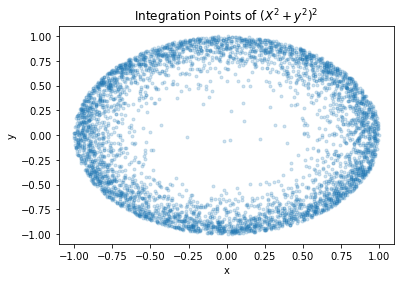

,theta,r,value,x,y
0,3.221370,0.262516,0.004749,-0.261681,-0.020921
1,0.311119,0.329352,0.011766,0.313540,0.100822
2,6.089046,0.222314,0.002443,0.218137,-0.042889
3,5.124275,0.051729,0.000007,0.020709,-0.047403
4,0.229249,0.384584,0.021876,0.374522,0.087395
...,...,...,...,...,...
253,2.713178,0.998702,0.994817,-0.908444,0.414890
254,3.806349,0.994355,0.977609,-0.782624,-0.613385
255,1.940069,0.992522,0.970424,-0.358238,0.925617
256,3.649458,0.992291,0.969521,-0.867049,-0.482564


In [158]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

def f(theta, r):
    """ The function to integrate. """
    # Convert to rectangular coordinates
    x = r*np.cos(theta)
    y = r*np.sin(theta)
    
    # Evaluate result
    return (x**2 + y**2)**2 

def half(t):
    """ Finds radius which divides an annulus into two equal volumes.  """
    return np.sqrt((t[1]**2)/2 + (t[0]**2)/2)


def estimate_polar(N, boundTheta, boundR, V):
    """ Monte-Carlo estimate in polar coordinates. """
    # Generate sample points
    dfPoints = pd.DataFrame(
        columns = ("theta", "r"), 
        data = np.random.uniform((boundTheta[0],boundR[0]**2), (boundTheta[1],boundR[1]**2), (N, 2)))

    # Transform R for evenly distributed density of points along radius
    dfPoints["r"] = np.sqrt(dfPoints["r"])

    # Use numpy vectorize calculation of function value 
    dfPoints["value"] = np.vectorize(f)(dfPoints["theta"], dfPoints["r"])

    return dfPoints["value"].mean()*V \
            ,dfPoints["value"].var() \
            ,dfPoints
    
def rss_polar(N, k, boundTheta, boundR, maxError, maxDepth, depth=1):
    """ Recursive stratified sampling implementation. """
    
    # Calculate the volume of this sector of the annulus
    V = (boundR[1]**2)*(abs(boundTheta[1] - boundTheta[0])/2) - (boundR[0]**2)*(abs(boundTheta[1] - boundTheta[0])/2)
    
    # If termination criteria not met yet
    if(depth < maxDepth
      and N > 4):
        
        # Sample for estimate of variance
        dfSampleTheta1 = pd.DataFrame(
            columns = ("theta", "r"), 
            data = np.random.uniform((boundTheta[0],boundR[0]**2), (np.mean(boundTheta),boundR[1]**2), (k, 2)))
        dfSampleTheta2 = pd.DataFrame(
            columns = ("theta", "r"), 
            data = np.random.uniform((np.mean(boundTheta),boundR[0]**2), (boundTheta[1],boundR[1]**2), (k, 2)))
        dfSampleR1 = pd.DataFrame(
            columns = ("theta", "r"), 
            data = np.random.uniform((boundTheta[0],boundR[0]**2), (boundTheta[1],half(boundR)**2), (k, 2)))
        dfSampleR2 = pd.DataFrame(
            columns = ("theta", "r"), 
            data = np.random.uniform((boundTheta[0],half(boundR)**2), (boundTheta[1],boundR[1]**2), (k, 2)))
        
        # Calculate values
        dfSampleTheta1["value"] = np.vectorize(f)(dfSampleTheta1["theta"], dfSampleTheta1["r"])
        dfSampleTheta2["value"] = np.vectorize(f)(dfSampleTheta2["theta"], dfSampleTheta2["r"])
        dfSampleR1["value"] = np.vectorize(f)(dfSampleR1["theta"], dfSampleR1["r"])
        dfSampleR2["value"] = np.vectorize(f)(dfSampleR2["theta"], dfSampleR2["r"])
        
        # Calculate the combined standard error of the samples
        sample = pd.concat([dfSampleTheta1, dfSampleTheta2, dfSampleR1, dfSampleR2], axis=0)
        sampleVariance = sample["value"].var()
        errorSample = np.sqrt(sampleVariance / sample.shape[0]) * V
        
        # Error is a termination criteria
        if(errorSample <= maxError):
            valueFinal, varianceFinal, dfPointsFinal = estimate_polar(N, boundTheta, boundR, V)
        else:    
            # Calculate variances
            dfSampleTheta1Variance = dfSampleTheta1["value"].var()
            dfSampleTheta2Variance = dfSampleTheta2["value"].var()
            dfSampleR1Variance = dfSampleR1["value"].var()
            dfSampleR2Variance = dfSampleR2["value"].var()
            
            # Choose the dimension to split on such that the sum of standard errors in two dimensions is reduced 
            #if(np.sqrt(dfSampleTheta1Variance) + np.sqrt(dfSampleTheta2Variance) 
            #   < np.sqrt(dfSampleR1Variance) + np.sqrt(dfSampleR2Variance)):
            if(dfSampleTheta1Variance/(4*dfSampleTheta1.shape[0]) + dfSampleTheta2Variance/(4*dfSampleTheta2.shape[0]) 
               < dfSampleR1Variance/(4*dfSampleR1.shape[0]) + dfSampleR2Variance/(4*dfSampleR2.shape[0])):
                # Split along Theta direction
                Na = int(N*np.sqrt(dfSampleTheta1Variance)/(np.sqrt(dfSampleTheta1Variance)+np.sqrt(dfSampleTheta2Variance)))
                Na = max(2, min(N-2, Na))
                Nb = N - Na
                #print(f"Na:{Na} Nb:{Nb}")
                valueSub1, varianceSub1, dfPointsSub1 = rss_polar(Na, k, (boundTheta[0], np.mean(boundTheta)), boundR, maxError, maxDepth, depth+1)
                valueSub2, varianceSub2, dfPointsSub2 = rss_polar(Nb, k, (np.mean(boundTheta), boundTheta[1]), boundR, maxError, maxDepth, depth+1)  
            else:
                # Else split along R direction
                Na = int(N*np.sqrt(dfSampleR1Variance)/(np.sqrt(dfSampleR1Variance)+np.sqrt(dfSampleR2Variance)))
                Na = max(2, min(N-2, Na))
                Nb = N - Na
                #print(f"Na:{Na} Nb:{Nb}")
                valueSub1, varianceSub1, dfPointsSub1 = rss_polar(Na, k, boundTheta, (boundR[0], half(boundR)), maxError, maxDepth, depth+1)
                valueSub2, varianceSub2, dfPointsSub2 = rss_polar(Nb, k, boundTheta, (half(boundR), boundR[1]), maxError, maxDepth, depth+1)
                            
            # Final estimate
            #varianceFinal = (Na*varianceSub1 + Na*varianceSub2)/(Na + Nb)
            meanSub1 = dfPointsSub1["value"].mean()
            meanSub2 = dfPointsSub2["value"].mean()
            varianceFinal = (1/(Na+Nb))*((Na)*varianceSub1+(Nb)*varianceSub2+Na*Nb*((meanSub1-meanSub2)**2)/(Na+Nb))

            valueFinal = valueSub1 + valueSub2
            dfPointsFinal = pd.concat([dfPointsSub1, dfPointsSub2], axis=0)

    # Otherwise terminate here with a Monte-Carlo estimate of remaining points    
    else: 
        valueFinal, varianceFinal, dfPointsFinal = estimate_polar(N, boundTheta, boundR, V)

    # Return final values
    return valueFinal, varianceFinal, dfPointsFinal
        
# Maximum number of sample points
N = 4400
boundTheta = (0, 2*np.pi)
boundR = (0, 1)
maxError = 0.0001
maxDepth = 10

calculatedIntegral, varianceValue, df = rss_polar(N, 100, boundTheta, boundR, maxError, maxDepth)

# Transform the data
df["x"] = df["r"]*np.cos(df["theta"])
df["y"] = df["r"]*np.sin(df["theta"])

plt.scatter(df["x"], df["y"], marker='.', alpha=0.2)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Integration Points of $(X^2+y^2)^2$")
plt.show()

df

In [160]:
# Calculate the estimated error
error = np.sqrt(varianceValue/N)*np.pi

# Analytical solution of the integral
analyticalIntegral = np.pi/3

# Print the results 
print(f"Estimate standard error: {error}")
print(f"Calculated integral: {calculatedIntegral}")
print(f"Analytical solution: {analyticalIntegral}")
print(f"Percent error is: {(100*(calculatedIntegral-analyticalIntegral)/analyticalIntegral):.4f} %")


Estimate standard error: 0.011088527114691753
Calculated integral: 1.0444735731326455
Analytical solution: 1.0471975511965976
Percent error is: -0.2601 %


In [124]:
import numpy as np

n1 = 50
n2 = 50
sample1 = np.random.uniform(1, -1, n1)
sample2 = np.random.uniform(1, -1, n2)

var1 = np.var(sample1)
var2 = np.var(sample2)
m1 = np.mean(sample1)
m2 = np.mean(sample2)
var3 = np.var(np.concatenate([sample1, sample2], axis=0))
var4 = (n1*(var1+(m1-m2)**2) + n2*(var2+(m2-m1)**2))/(n1+n2)
var4 = ((n1-1)*var1 + (n2-1)*var2)/(n1+n2 -2)
var4 = ((n1)*var1 + (n2)*var2)/(n1+n2)
var4 = (1/(n1+n2-1))*((n1-1)*var1+(n2-1)*var2+n1*n2*((m1-m2)**2)/(n1+n2))
var4 = (1/(n1+n2))*((n1)*var1+(n2)*var2+n1*n2*((m1-m2)**2)/(n1+n2))

print(var1)
print(var2)
print(var3)
print(var4)


0.35644985771692583
0.3137313580478774
0.33607421837230705
0.3360742183723071


In [ ]:
import numpy as np
import pandas as pd

n1 = 50
n2 = 50
sample1 = pd.DataFrame(np.random.uniform(1, -1, n1))
sample2 = pd.DataFrame(np.random.uniform(1, -1, n2))

var1 = sample1.var()
var2 = sample2.var()
m1 = sample1.mean()
m2 = sample2.mean()
var3 = pd.concat([sample1, sample2], axis=0).var()
var4 = (n1*(var1+(m1-m2)**2) + n2*(var2+(m2-m1)**2))/(n1+n2)
var4 = ((n1-1)*var1 + (n2-1)*var2)/(n1+n2 -2)
var4 = ((n1)*var1 + (n2)*var2)/(n1+n2)
var4 = (1/(n1+n2-1))*((n1-1)*var1+(n2-1)*var2+n1*n2*((m1-m2)**2)/(n1+n2))
var4 = (1/(n1+n2))*((n1)*var1+(n2)*var2+n1*n2*((m1-m2)**2)/(n1+n2))

print(var1)
print(var2)
print(var3)
print(var4)
